# Notebook de test

Notebook de Mickael MELKOWSKI

## Preprocessing des data

### Conversion en 256*256 et masking

In [3]:
# import
import cv2
import os
import pathlib

#### Config

In [4]:
# config
data_folder_path = pathlib.Path("/home/tylio/code/Project_radio_pulmo/code/radio_pulmo/data/raw/COVID-19_Radiography_Dataset")
output_path = pathlib.Path("/home/tylio/code/Project_radio_pulmo/code/radio_pulmo/data/processed/covid_19_masked_tiny")
folder_to_process = ["Lung_Opacity","COVID","Normal","Viral_Pneumonia"]

# Setting to output a smaller dataset of tiny_size number of images
make_tiny = True
tiny_size = 100



#### Converting

In [ ]:
for img_type in  folder_to_process:
    print(f"Processing folder: {img_type}")

    img_folder_path = data_folder_path / img_type / "images"
    mask_folder_path = data_folder_path / img_type / "masks"

    output_folder_path = output_path / img_type
    output_folder_path.mkdir(parents=True, exist_ok=True)

    nb_image_done = 0
    for image_name, mask_name in zip(os.listdir(img_folder_path),
                                     os.listdir(mask_folder_path)):

        image_path = img_folder_path / image_name
        mask_path = mask_folder_path / mask_name

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # resized to mask size
        image = cv2.resize(image, dsize = (256, 256)) # fixed size to mask size

        # masking
        res =  cv2.bitwise_and(image, image, mask=mask)

        # Write masked image
        output_image_name = image_name + '_masked.png'
        cv2.imwrite(output_folder_path / output_image_name, res)

        nb_image_done += 1
        if make_tiny and nb_image_done >= tiny_size:
            break

    print(f"Processing folder: {img_type} done.")

### Affichage d'une image par type.

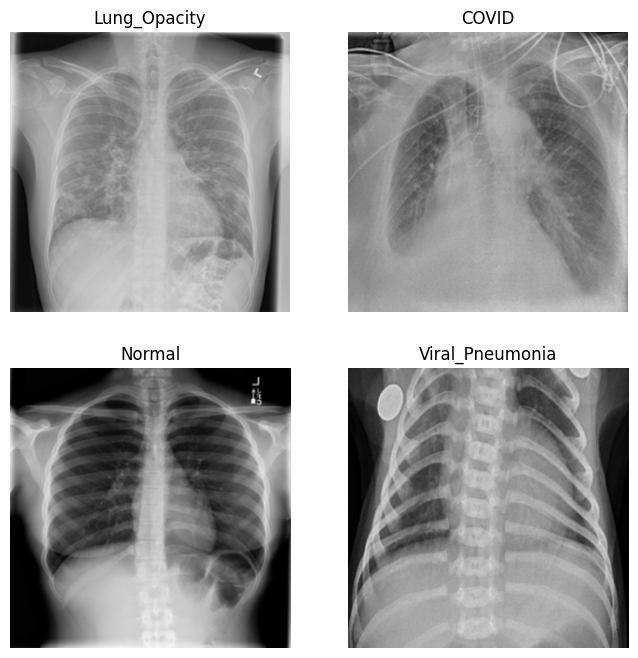

In [15]:
# affichage d'une images par type
import matplotlib.pyplot as plt
import numpy as np
import random

plt.figure(figsize=(8,8))
j=1
for img_type in  folder_to_process:
    img_folder_path = data_folder_path / img_type / "images"

    list_dir = os.listdir(img_folder_path)
    i = random.randint(0, len(list_dir))

    image_path = img_folder_path / list_dir[i]
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    plt.subplot(2,2,j)
    plt.axis('off')
    plt.imshow(image)
    plt.title(img_type)
    j+=1

## Premiers models

### Tensorflow

In [3]:
# import
import pathlib

import numpy as np

import tensorflow as tf
import tensorrt
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D

from keras.utils import to_categorical

import matplotlib.pyplot as plt
from matplotlib import cm

2024-10-21 16:09:51.907318: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-21 16:09:52.265812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 16:09:52.413541: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 16:09:52.449916: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 16:09:52.705349: I tensorflow/core/platform/cpu_feature_guar

#### Config

In [4]:
data_dir = pathlib.Path("/home/tylio/code/Project_radio_pulmo/code/radio_pulmo/data/processed/covid_19_masked_tiny")
img_height, img_width = 256, 256
batch_size = 32

#### Loading data

In [5]:
# training set
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    color_mode= "grayscale",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 400 files belonging to 4 classes.
Using 320 files for training.


I0000 00:00:1729519796.365872   59381 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729519796.680580   59381 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729519796.680622   59381 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729519796.682599   59381 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729519796.682629   59381 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [6]:
# validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    color_mode= "grayscale",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 400 files belonging to 4 classes.
Using 80 files for validation.


#### Keras to numpy

In [7]:
# Transform keras dataset to numpy ndarray
# from https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset
# For train data
all_images = []
all_labels = []

for images, labels in train_ds.take(-1):  # -1 takes all
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

X_train = np.concatenate(all_images)
y_train = np.concatenate(all_labels)

# For test data
all_images = []
all_labels = []

for images, labels in val_ds.take(-1):  # -1 takes all
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

X_test = np.concatenate(all_images)
y_test = np.concatenate(all_labels)


2024-10-21 16:09:58.052475: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-21 16:09:58.083455: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Normalization & Encoding

In [8]:
# normalization
X_train = X_train / 255
X_test = X_test / 255

# encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Test sur archi LeNet

### Definition du modele

In [9]:
# Architecture du modèle
inputs=Input(shape = (256, 256,1), name = "Input")
conv_1 = Conv2D(filters = 30,                     # Nombre de filtres
                kernel_size = (5, 5),            # Dimensions du noyau
                padding = 'valid',               # Mode de Dépassement
                input_shape = (28, 28, 1),       # Dimensions de l'image en entrée
                activation = 'relu')             # Fonction d'activation
max_pool_1 = MaxPooling2D(pool_size = (2, 2))
conv_2 = Conv2D(filters = 16,                    
                kernel_size = (3, 3),          
                padding = 'valid',             
                activation = 'relu')
max_pool_2 = MaxPooling2D(pool_size = (2, 2))
flatten = Flatten()
dropout = Dropout(rate = 0.2)
dense_1 = Dense(units = 128,
                activation = 'relu')
dense_2 = Dense(units = 4,
                activation = 'softmax')

x=conv_1(inputs)
x=max_pool_1(x)
x=conv_2(x)
x=max_pool_2(x)
x=dropout(x)
x=flatten(x)
x=dense_1(x)
outputs=dense_2(x)

lenet = Model(inputs = inputs, outputs = outputs)

/home/tylio/code/radio_pulmo_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compilation et fitting

In [10]:
# Compilation
lenet.compile(loss='categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation

# Entraînement_1
nb_epochs = 16
nb_batch_size = 200

training_history_lenet = lenet.fit(X_train, y_train,           # données
                                   validation_split = 0.2,     # split de test
                                   epochs = nb_epochs,         # nombre d'epochs
                                   batch_size = nb_batch_size) # taille des batchs

# extraire les précisions sur les bases d'entraînement et de test obtenues pendant l'entraînement
train_acc_lenet = training_history_lenet.history['accuracy']
val_acc_lenet = training_history_lenet.history['val_accuracy']

Epoch 1/16


I0000 00:00:1729519798.994995   68998 service.cc:146] XLA service 0x7f589c003e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729519798.995019   68998 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2024-10-21 16:09:59.032298: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-21 16:09:59.164853: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1/2 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.3250 - loss: 1.3841

I0000 00:00:1729519808.926204   68998 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-10-21 16:10:09.345184: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_639', 4 bytes spill stores, 4 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 0.3245 - loss: 1.4071 - val_accuracy: 0.2344 - val_loss: 1.4601
Epoch 2/16
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4385 - loss: 1.2491 - val_accuracy: 0.3750 - val_loss: 1.3217
Epoch 3/16
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5994 - loss: 1.0638 - val_accuracy: 0.4375 - val_loss: 1.3271
Epoch 4/16
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6961 - loss: 0.8691 - val_accuracy: 0.5000 - val_loss: 1.2826
Epoch 5/16
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7320 - loss: 0.6805 - val_accuracy: 0.4375 - val_loss: 1.3211
Epoch 6/16
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7901 - loss: 0.5489 - val_accuracy: 0.5000 - val_loss: 1.5029
Epoch 7/16
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8330 - loss: 0.4319 - val_accuracy: 0.4844 - val_loss: 1.2604
Epoch 8/16
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9158 - loss: 0.3045 - val_accuracy: 0.5000 - val_loss: 1.1851
Epoch 9/16
2

### Plot

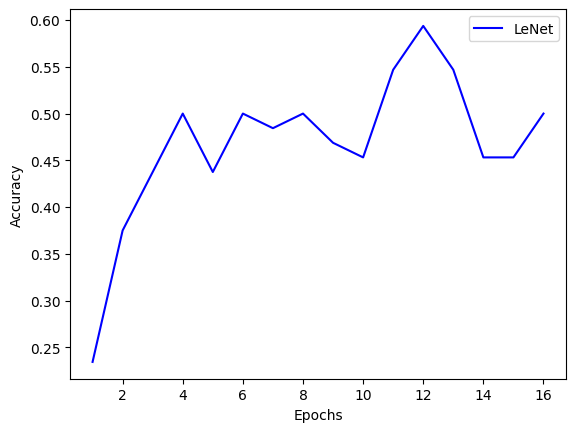

In [11]:
# Courbe du score de test du réseau LeNet
plt.plot(np.arange(1 , nb_epochs + 1, 1),
         val_acc_lenet, 
         label = 'LeNet',
         color = 'blue')
# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Affichage de la légende
plt.legend()
# Affichage de la figure
plt.show()

## Test load direct

Cas d'utilisation de Keras dataset directement plutot que de convertir en numpy

### Import

In [12]:
# import
import cv2
import os
import pathlib


import numpy as np

import tensorrt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D

from keras.utils import to_categorical

import matplotlib.pyplot as plt

### Load dataset

In [13]:
data_dir = pathlib.Path("/home/tylio/code/Project_radio_pulmo/code/radio_pulmo/data/processed/covid_19_masked_tiny")
img_height, img_width = 256, 256
batch_size = 32

# test sans passer par la recup à la main
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",  # Automatically infer labels from subdirectories
    label_mode="categorical",  # For multi-class classification
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),  # Resize images to a standard size
    batch_size=32,  # Set the batch size
    color_mode= "grayscale",
    shuffle=True  # Shuffle the dataset for better training
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",  # Automatically infer labels from subdirectories
    label_mode="categorical",  # For multi-class classification
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),  # Resize images to a standard size
    batch_size=32,  # Set the batch size
    color_mode= "grayscale",
    shuffle=True  # Shuffle the dataset for better training
)

Found 400 files belonging to 4 classes.
Using 320 files for training.
Found 400 files belonging to 4 classes.
Using 80 files for validation.


### Model definition

In [ ]:
# model definition
num_classes = 4

model = Sequential([
    Input(shape=(img_height, img_width, 1)),
    Normalization(axis=-1),  # Normalizes along the last axis (features), per batch ?
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # Replace num_classes with the actual number of classes --> 4
])

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [14]:
print(train_dataset.cardinality())

tf.Tensor(10, shape=(), dtype=int64)


### Fitting

In [15]:
# model.summary()
nb_epochs = 10
model_history = model.fit(train_dataset, epochs=nb_epochs)  # Adjust the number of epochs as needed

Epoch 1/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.2380 - loss: 446.7656
Epoch 2/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5453 - loss: 9.0281
Epoch 3/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6763 - loss: 1.1962
Epoch 4/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8699 - loss: 0.3508
Epoch 5/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9077 - loss: 0.2430
Epoch 6/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9708 - loss: 0.0962


### Plot

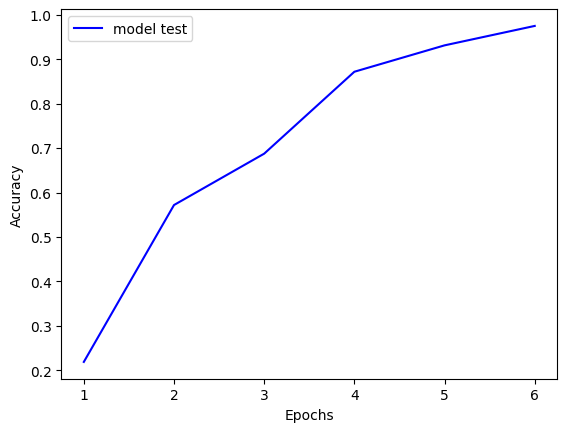

In [16]:
# Courbe du score de test du réseau test
# train_acc_model = model_history.history['accuracy']
val_acc_model = model_history.history['accuracy']

plt.plot(np.arange(1 , nb_epochs + 1, 1),
         val_acc_model, 
         label = 'model test',
         color = 'blue')
# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Affichage de la légende
plt.legend()
# Affichage de la figure
plt.show()

### Prediction model test

In [17]:
# import 
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Make Predictions on the Dataset
# Get the true labels and predictions
true_labels = []
pred_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert categorical labels to integer
    pred_labels.extend(np.argmax(preds, axis=1))  # Convert softmax output to predicted class


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


#### Confusion matrix

In [19]:
# Confusion matrix
# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Optionally normalize the confusion matrix (if you want percentage instead of raw counts)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

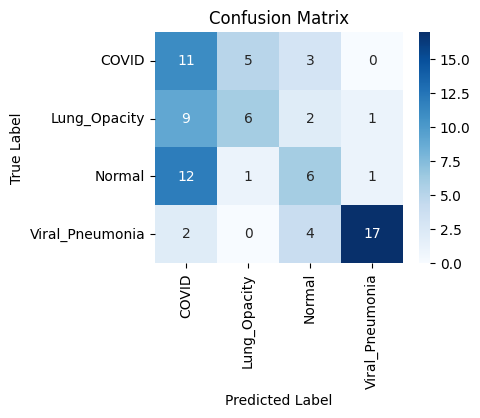

In [20]:
# Visualization 
# get real label names
class_names = test_dataset.class_names

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()